#### **Declare path to project directory**

In [1]:
path_to_directory = "/home/morais/data_science_project"

#### **Declare path to train and test files**

In [2]:
file_tag = "class_financial distress"

train_filename = f"{path_to_directory}/datasets/{file_tag}_train_smote.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test_lowvar.csv"

# **Classification**
## **Evaluation**
### Training Strategies
#### train_test_split function

In [3]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame
import os


# file_tag = "class_financial distress"
index_col = None
target = "CLASS"
data_train: DataFrame = read_csv(train_filename, index_col=index_col)
data_test: DataFrame = read_csv(test_filename, index_col=index_col)

# Remove the "Financial Distress" column
if "Financial Distress" in data_train.columns:
    data_train.drop(columns=["Financial Distress"], inplace=True)
if "Financial Distress" in data_test.columns:
    data_test.drop(columns=["Financial Distress"], inplace=True)

labels: list = list(data_train[target].unique())
labels.sort()
print(f"Labels={labels}")
print(data_train.shape)
print(data_test.shape)

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data_train[data_train[target] == negative])+len(data_test[data_test[target] == negative]),
        len(data_train[data_train[target] == positive])+len(data_test[data_test[target] == positive]),
    ]
}

y_trn: array = data_train.pop(target).to_list()
X_trn: ndarray = data_train.values

y_tst: array = data_test.pop(target).to_list()
X_tst: ndarray = data_test.values

Labels=[np.int64(0), np.int64(1)]
(5516, 77)
(716, 77)


<Axes: title={'center': 'Data distribution per dataset'}>

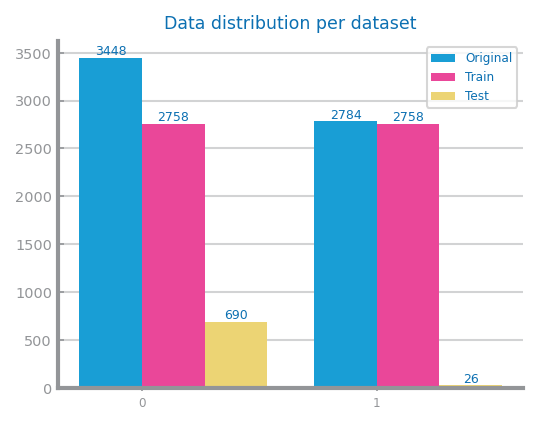

In [4]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
trnX = X_trn
trnY = y_trn
tstX = X_tst
tstY = y_tst

train: DataFrame = concat(
    [DataFrame(trnX, columns=data_train.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"{path_to_directory}/datasets/{file_tag}_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data_test.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"{path_to_directory}/datasets/{file_tag}_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure()
plot_multibar_chart(labels, values, title="Data distribution per dataset")

#### Reading Train and Test datasets

In [5]:
from pandas import read_csv


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

eval_metric = "accuracy"
train_filename = f"{path_to_directory}/datasets/{file_tag}_train.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test.csv"

trnX: ndarray
tstX: ndarray
trnY: array
tstY: array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]


### Estimators and Models

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
pred_trnY: array = clf.predict(trnX)
print(f"Score over Train: {clf.score(trnX, trnY):.3f}")
print(f"Score over Test: {clf.score(tstX, tstY):.3f}")

Score over Train: 0.797
Score over Test: 0.644


### Evaluation
#### Accuracy, Recall and Precision

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_tstY: array = clf.predict(tstX)

acc: float = accuracy_score(tstY, pred_tstY)
recall: float = recall_score(tstY, pred_tstY)
prec: float = precision_score(tstY, pred_tstY)
print(f"accuracy={acc:.3f} recall={recall:.3f} precision={prec:.3f}")

accuracy=0.644 recall=0.962 precision=0.090


#### Confusion Matrix

In [8]:
from pandas import unique
from sklearn.metrics import confusion_matrix

labels: list = list(unique(tstY))
labels.sort()

prdY: array = clf.predict(tstX)
cnf_mtx_tst: ndarray = confusion_matrix(tstY, prdY, labels=labels)
print(cnf_mtx_tst)

[[436 254]
 [  1  25]]


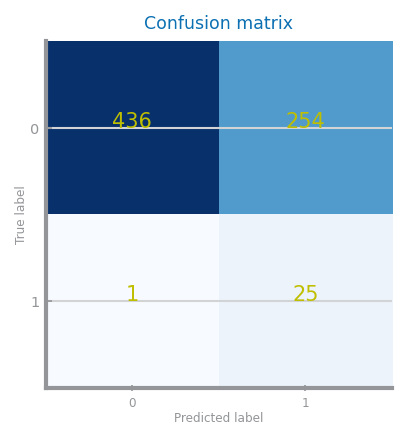

In [9]:
from itertools import product
from numpy import ndarray, set_printoptions, arange
from matplotlib.pyplot import gca, cm
from matplotlib.axes import Axes


def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cm.Blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(
            j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center"
        )
    return ax


figure()
plot_confusion_matrix(cnf_mtx_tst, labels)
show()

#### ROC Charts


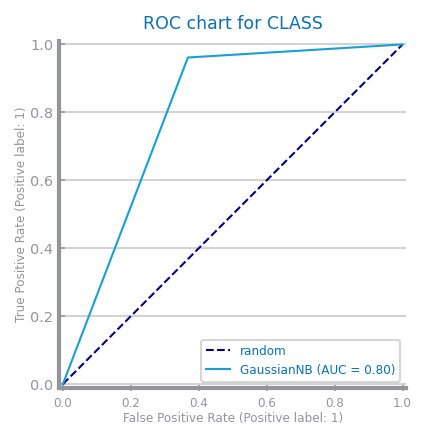

In [10]:
from sklearn.metrics import RocCurveDisplay
from config import ACTIVE_COLORS


def plot_roc_chart(tstY: ndarray, predictions: dict, ax: Axes = None, target: str = "class") -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title("ROC chart for %s" % target)

    ax.plot(
        [0, 1],
        [0, 1],
        color="navy",
        label="random",
        linewidth=1,
        linestyle="--",
        marker="",
    )
    models = list(predictions.keys())
    for i in range(len(models)):
        RocCurveDisplay.from_predictions(
            y_true=tstY,
            y_pred=predictions[models[i]],
            name=models[i],
            ax=ax,
            color=ACTIVE_COLORS[i],
            linewidth=1,
        )
    ax.legend(loc="lower right", fontsize="xx-small")
    return ax


figure()
plot_roc_chart(tstY, {"GaussianNB": prdY}, target=target)
show()

<Figure size 600x450 with 0 Axes>

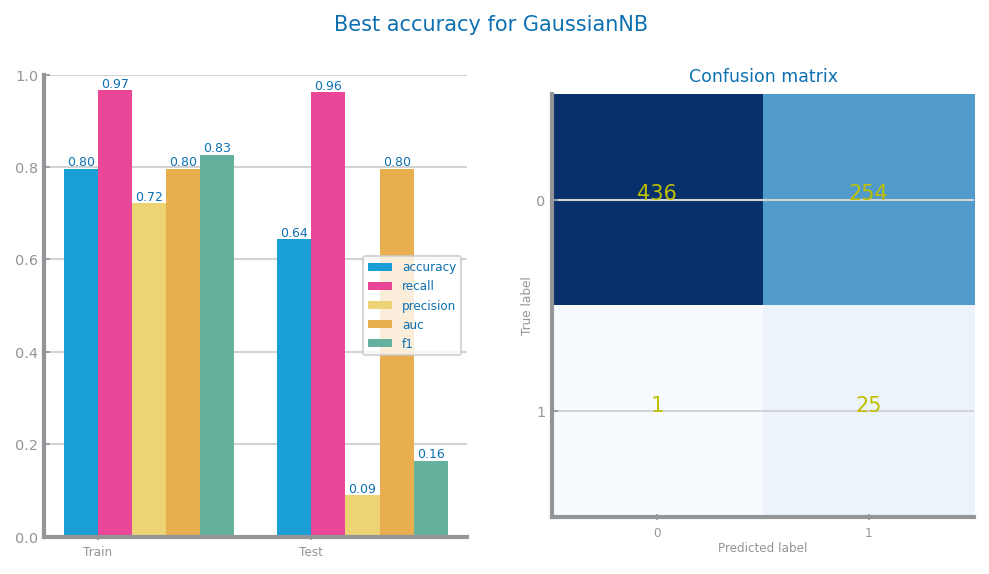

In [11]:
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, figure
from sklearn.metrics import roc_auc_score, f1_score
from dslabs_functions import plot_multibar_chart, HEIGHT

CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}


def plot_evaluation_results(
    model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray
) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs


model_description: dict = {"name": "GaussianNB", "metric": eval_metric, "params": ()}

prd_trn: array = clf.predict(trnX)
prd_tst: array = clf.predict(tstX)
figure()
plot_evaluation_results(model_description, trnY, prd_trn, tstY, prd_tst, labels)
savefig(
    f'{path_to_directory}/images/{model_description["name"]}_best_{model_description["metric"]}_eval.png', bbox_inches='tight'
)

show()

## **Naive Bayes**
### Study Naive Bayes Alternatives

In [12]:
from dslabs_functions import read_train_test_from_files

# file_tag = "class_financial distress"
# train_filename = f"{path_to_directory}/datasets/{file_tag}_train_oversampling.csv"
# test_filename = f"{path_to_directory}/datasets/{file_tag}_test_lowvar.csv"
target = "CLASS"
eval_metric = "accuracy"


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]


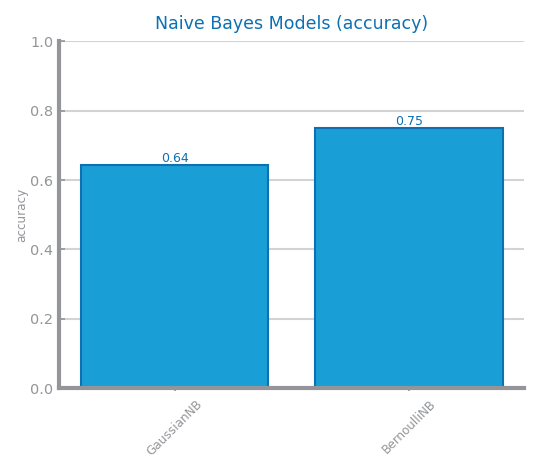

In [13]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

eval_metric = "accuracy"
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"{path_to_directory}/images/Set 2 - NB {eval_metric} study.png", bbox_inches='tight')
show()

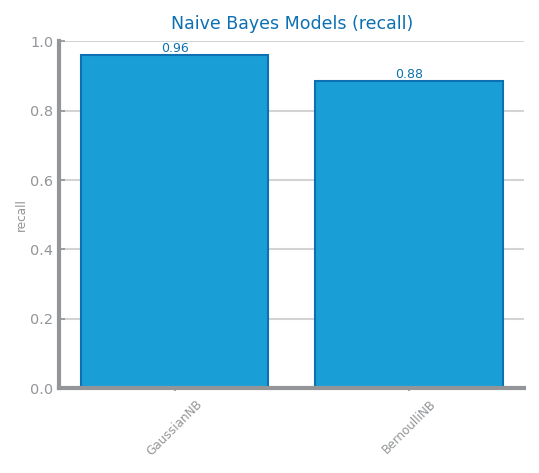

In [14]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"{path_to_directory}/images/Set 2 - NB recall study.png", bbox_inches='tight')
show()

### Performance Analysis

<Figure size 600x450 with 0 Axes>

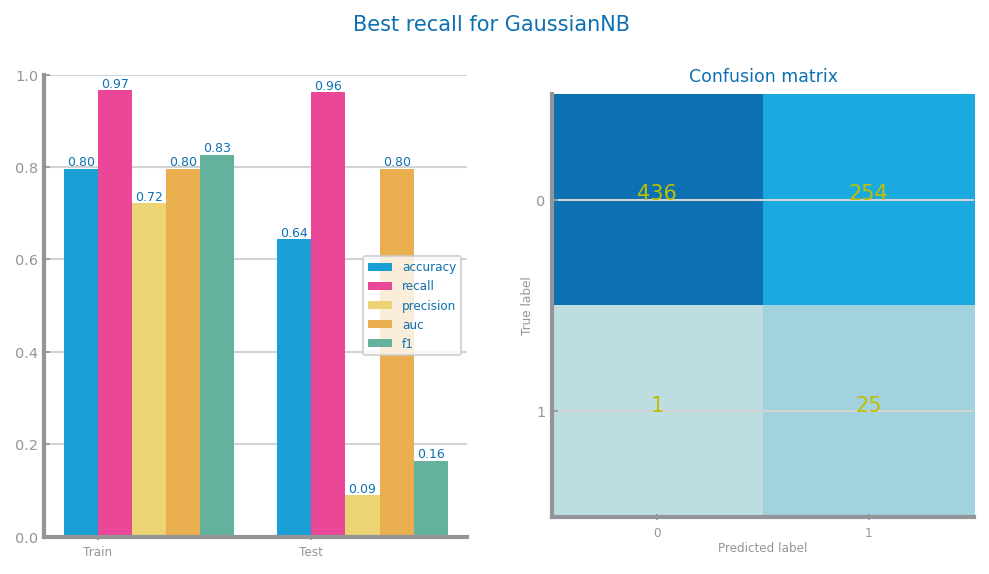

In [15]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - NB {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Overfitting
Since Naive Bayes does not result from specializations of simpler models, the overfitting study is not usual.

## **KNN**
### Paremeters study

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]
KNN best with k=1 and manhattan


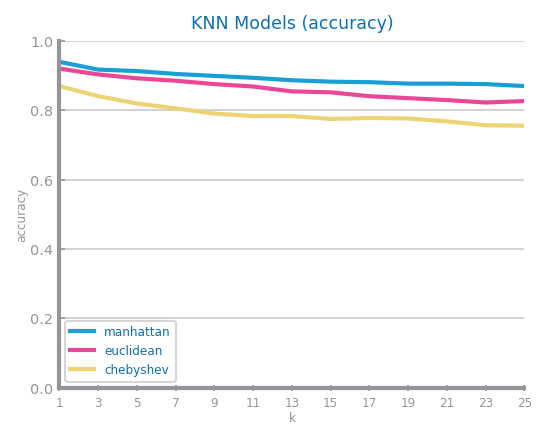

In [16]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f"KNN best with k={best_params['params'][0]} and {best_params['params'][1]}")
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

# file_tag = 'stroke'
# train_filename = 'data/stroke_train_smote.csv'
# test_filename = 'data/stroke_test.csv'
# target = 'stroke'
eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 2 - KNN {eval_metric} study.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 600x450 with 0 Axes>

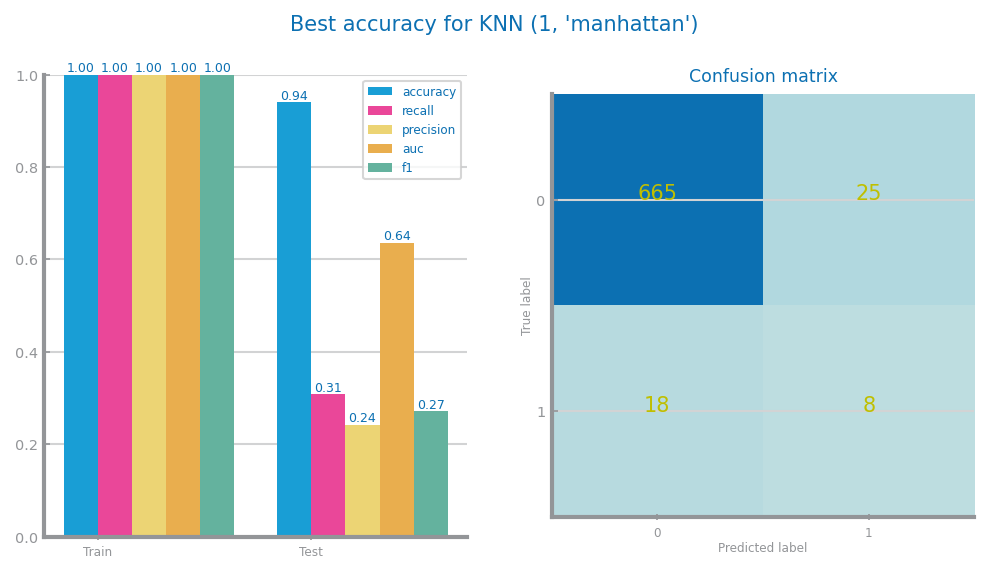

In [17]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - KNN {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Overfitting study


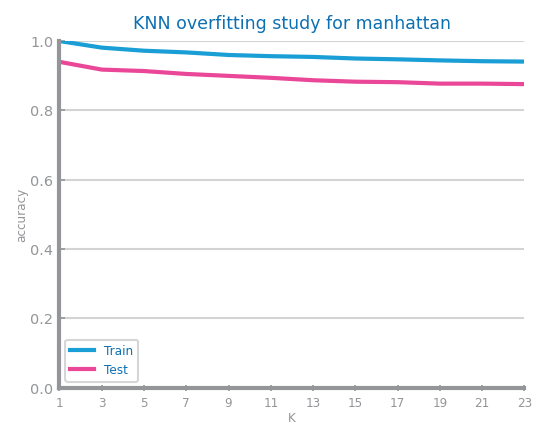

In [18]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - KNN overfitting.png", bbox_inches='tight')
show()

In this case, we don't see any overfitting, since the performance on both train and test sets keep the same trend.

Note that for KNN, **the specialization of a model increases when the number of neighbors decrease.**

## **Decision Trees**
### Paremeters study

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]
DT best with entropy and d=18


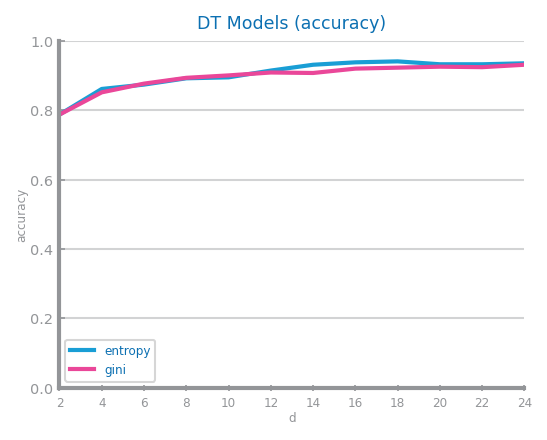

In [19]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

# file_tag = 'stroke'
# train_filename = 'data/stroke_train_smote.csv'
# test_filename = 'data/stroke_test.csv'
# target = 'stroke'
eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 2 - DT {eval_metric} study.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 600x450 with 0 Axes>

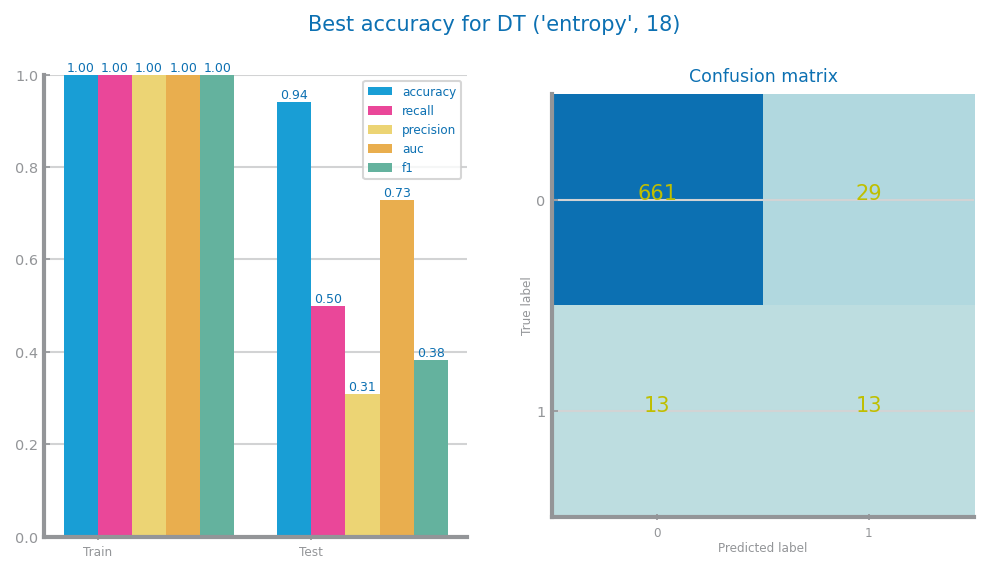

In [20]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - DT {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Variables importance

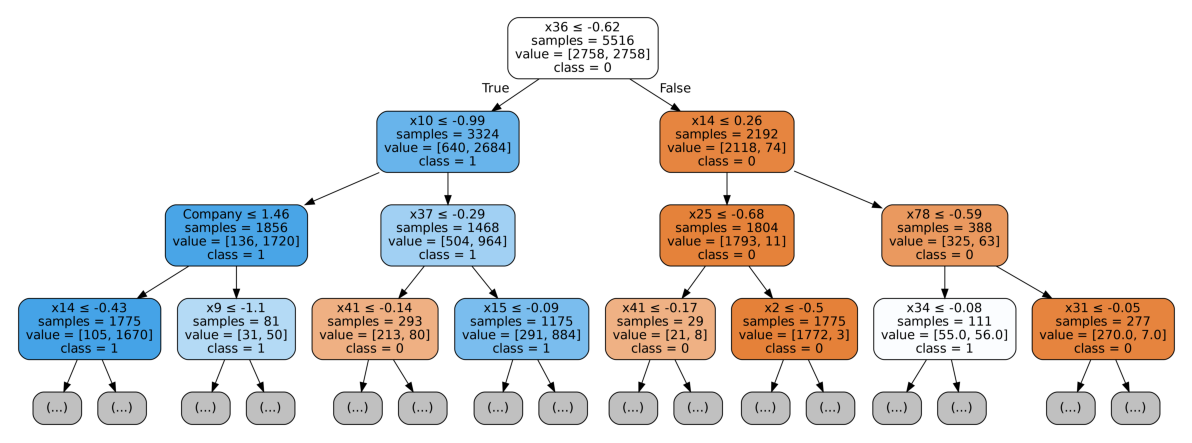

In [21]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"{path_to_directory}/images/Set 2 - DT {eval_metric} best tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(10,4))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

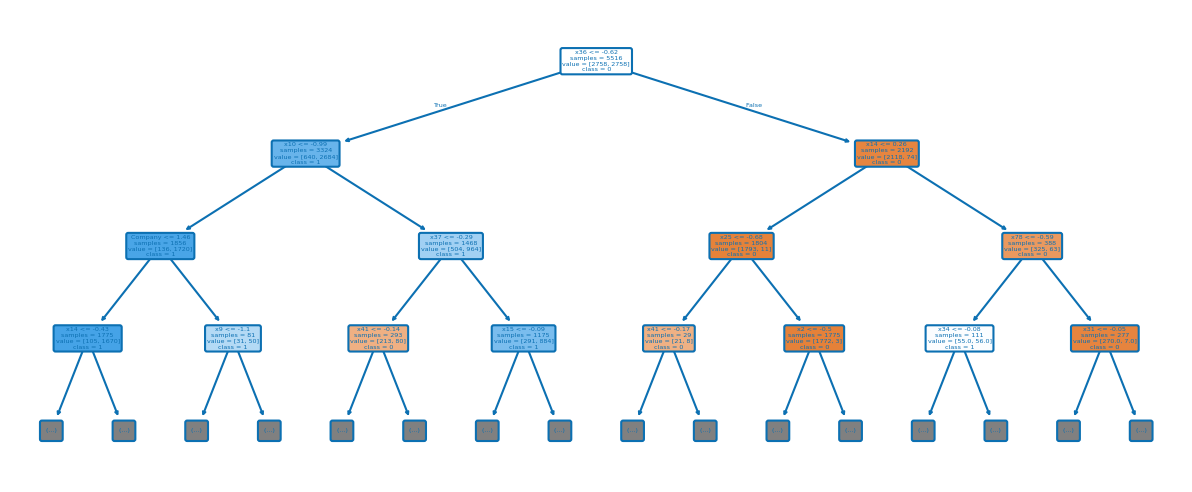

In [22]:
from sklearn.tree import plot_tree

figure(figsize=(10,4))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png", bbox_inches='tight')

1. x36 (0.49917805399730847)
2. x10 (0.06554645141228711)
3. x37 (0.03827312821116334)
4. x14 (0.030843699289346587)
5. x15 (0.01999077667359256)
6. x78 (0.019143537129770464)
7. x41 (0.018840928328162376)
8. Company (0.01601950835976055)
9. x64 (0.014068287583152329)
10. x21 (0.013232158510373458)
11. x9 (0.013126444671222115)
12. x39 (0.012766160687841265)
13. x44 (0.012495774921447076)
14. x26 (0.012447603411661423)
15. x25 (0.011596560164189055)
16. x51 (0.0102089460725131)
17. x28 (0.009942445376244684)
18. x58 (0.009821964542947951)
19. x54 (0.009592087169953654)
20. x31 (0.00882119457016007)
21. x48 (0.008689174023615062)
22. x80 (0.008250337130766774)
23. x72 (0.007961318181456614)
24. x70 (0.007899362006411774)
25. x7 (0.007398763994322718)
26. x74 (0.007229358361625566)
27. x59 (0.007153809410267588)
28. x53 (0.006837175569100613)
29. x5 (0.006790365290362264)
30. x34 (0.005582263080734092)
31. x11 (0.005420301424586651)
32. x60 (0.0054162104909440305)
33. x77 (0.005169833152

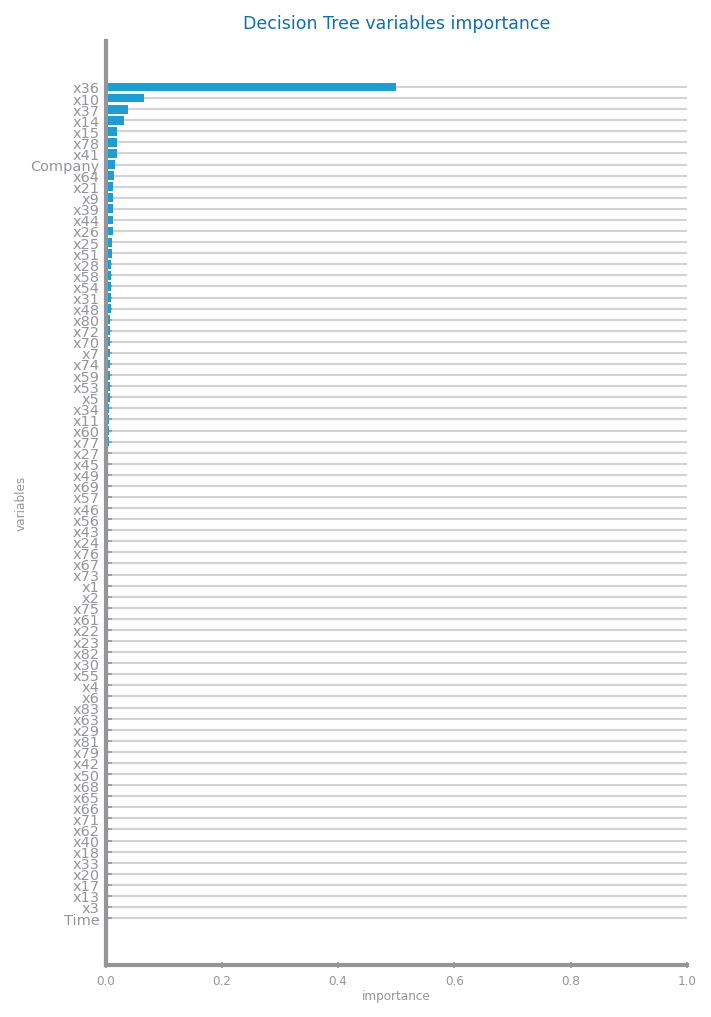

In [23]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - DT {eval_metric} vars ranking.png", bbox_inches='tight')

### Overfitting study

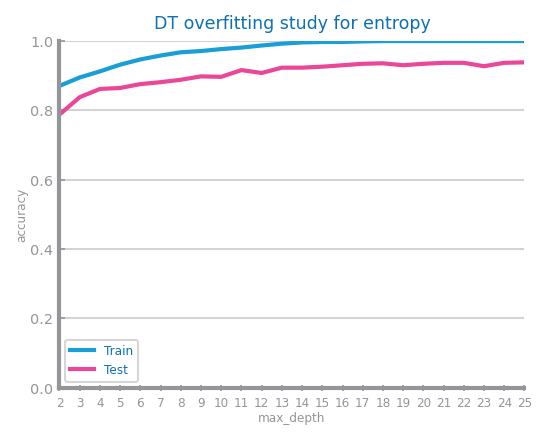

In [24]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - DT {eval_metric} overfitting.png", bbox_inches='tight')

In this case, there is no overfitting, since both the performance over the train and test datasets continue to improve.

## **Neural Networks**
### Multi Layer Perceptrons
#### Parameters study


Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]
MLP best for 2000 iterations (lr_type=constant and lr=0.5


<Figure size 600x450 with 0 Axes>

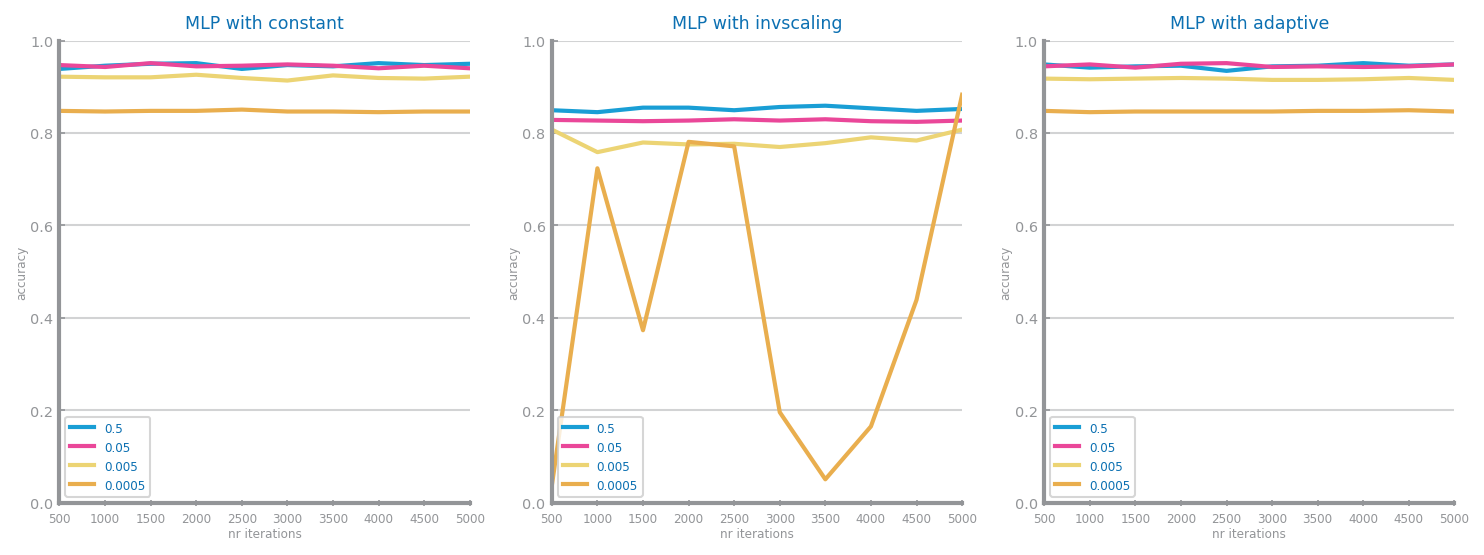

In [25]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

LAG: int = 500
NR_MAX_ITER: int = 5000


def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"MLP best for {best_params['params'][2]} iterations (lr_type={best_params['params'][0]} and lr={best_params['params'][1]}"
    )

    return best_model, best_params


# file_tag = "stroke"
# train_filename = "data/stroke_train_smote.csv"
# test_filename = "data/stroke_test.csv"
# target = "stroke"
# eval_metric = "accuracy"

# trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
#     train_filename, test_filename, target
# )
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 2 - MLP {eval_metric} study.png", bbox_inches='tight')
show()

#### Best model performance


<Figure size 600x450 with 0 Axes>

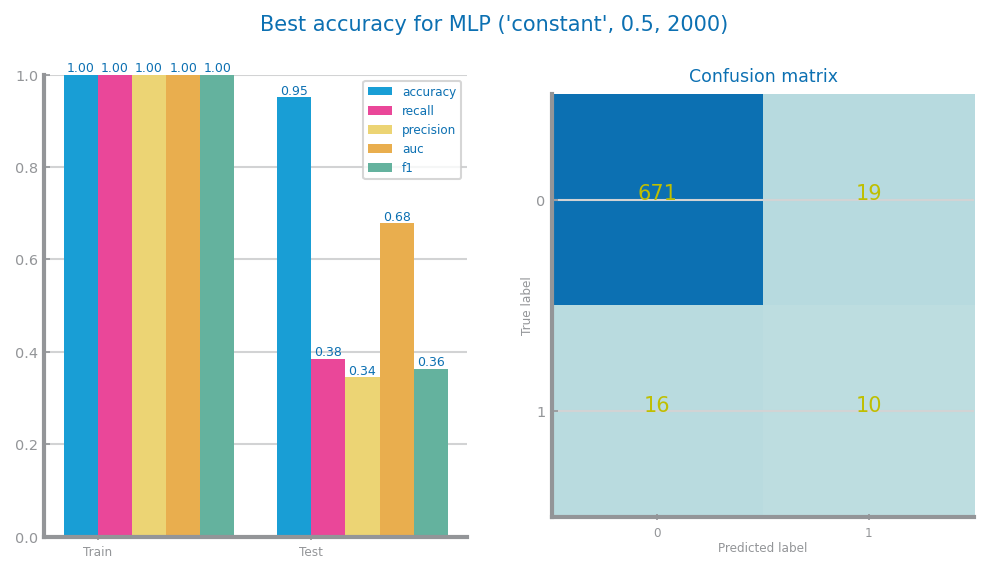

In [26]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - MLP {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

#### Overfitting study


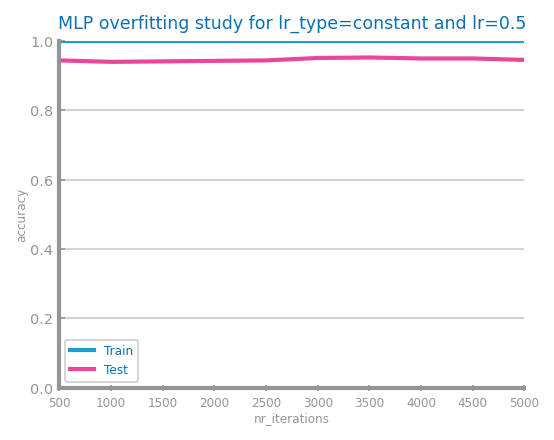

In [27]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]

nr_iterations: list[int] = [LAG] + [i for i in range(2 * LAG, NR_MAX_ITER + 1, LAG)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - MLP {eval_metric} overfitting.png", bbox_inches='tight')

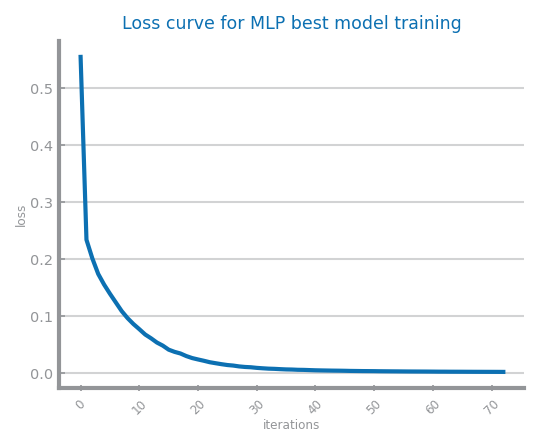

In [28]:
from numpy import arange
from dslabs_functions import plot_line_chart


figure()
plot_line_chart(
    arange(len(best_model.loss_curve_)),
    best_model.loss_curve_,
    title="Loss curve for MLP best model training",
    xlabel="iterations",
    ylabel="loss",
    percentage=False,
)
savefig(f"{path_to_directory}/images/Set 2 - MLP {eval_metric} loss curve.png")

## **Random Forests**
### Parameters study

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]
RF best for 100 trees (d=7 and f=0.7)


<Figure size 600x450 with 0 Axes>

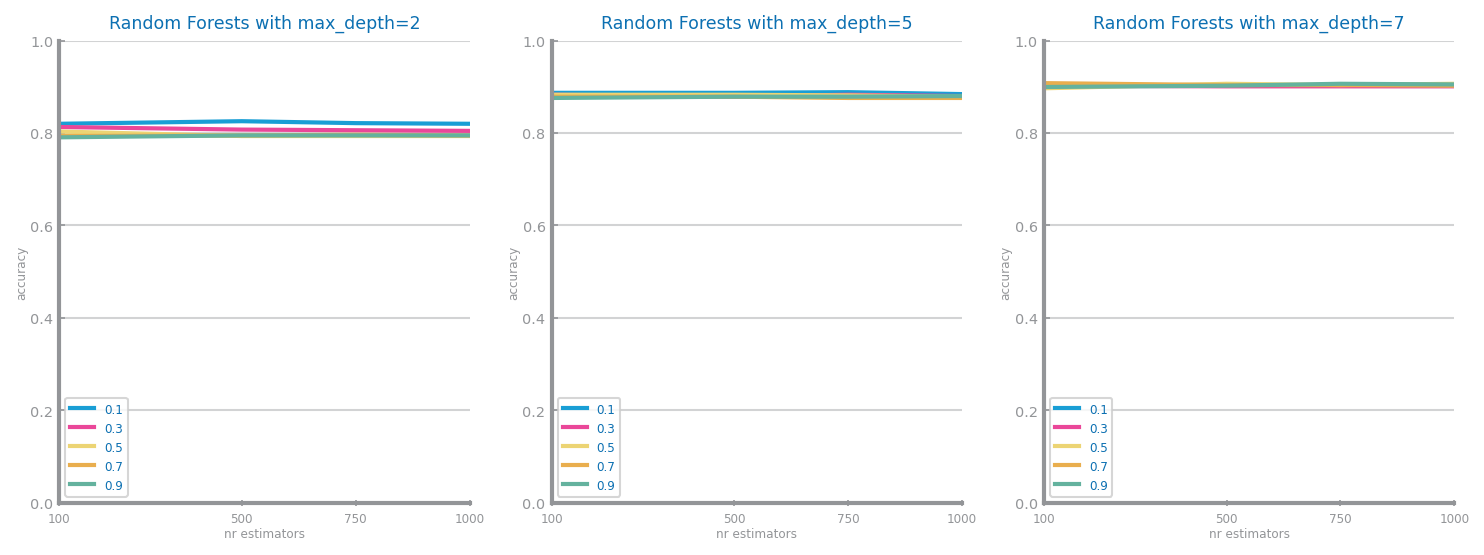

In [29]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"RF best for {best_params['params'][2]} trees (d={best_params['params'][0]} and f={best_params['params'][1]})"
    )
    return best_model, best_params


# file_tag = "stroke"
# train_filename = "data/stroke_train_smote.csv"
# test_filename = "data/stroke_test.csv"
# target = "stroke"
# eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 2 - RF {eval_metric} study.png", bbox_inches='tight')
show()

<Figure size 600x450 with 0 Axes>

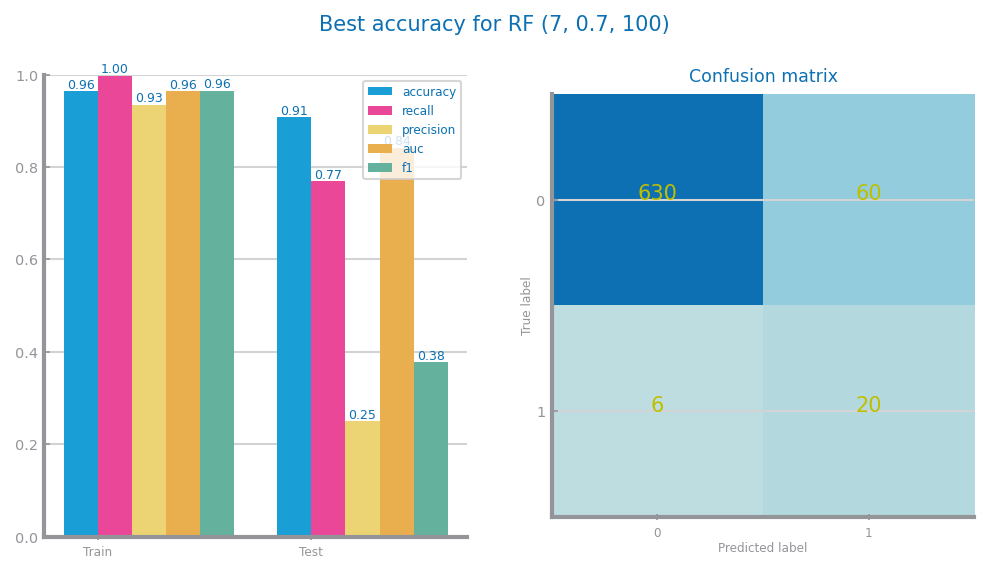

In [30]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - RF {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

1. x36 (0.48043642772590467)
2. x46 (0.16070112962645405)
3. x10 (0.04072756624998398)
4. x2 (0.039150392334349436)
5. x37 (0.02559097967055603)
6. x41 (0.019896674537826262)
7. x14 (0.01824508847000954)
8. x73 (0.010368356880376264)
9. x66 (0.009837578018515356)
10. x26 (0.009231478387215)
11. Company (0.007628033999682389)
12. x5 (0.0075484970765330416)
13. x22 (0.006969922423668909)
14. x80 (0.006575714739865596)
15. x49 (0.005725559905894798)
16. x50 (0.005686638823105762)
17. x74 (0.005310277789120864)
18. x59 (0.005180009449105822)
19. x39 (0.005163763693022723)
20. x64 (0.004943171541297557)
21. x28 (0.004831677814355279)
22. x31 (0.00476615218682397)
23. x44 (0.00452187362662864)
24. x23 (0.004415414846732581)
25. x51 (0.004279533292403121)
26. x30 (0.003836455682548121)
27. x7 (0.003796557095390589)
28. x58 (0.0037195563784775403)
29. x27 (0.003679784964316261)
30. x70 (0.003507587799020093)
31. x53 (0.0034177064047304123)
32. x24 (0.0033111524719635676)
33. x65 (0.00299277427

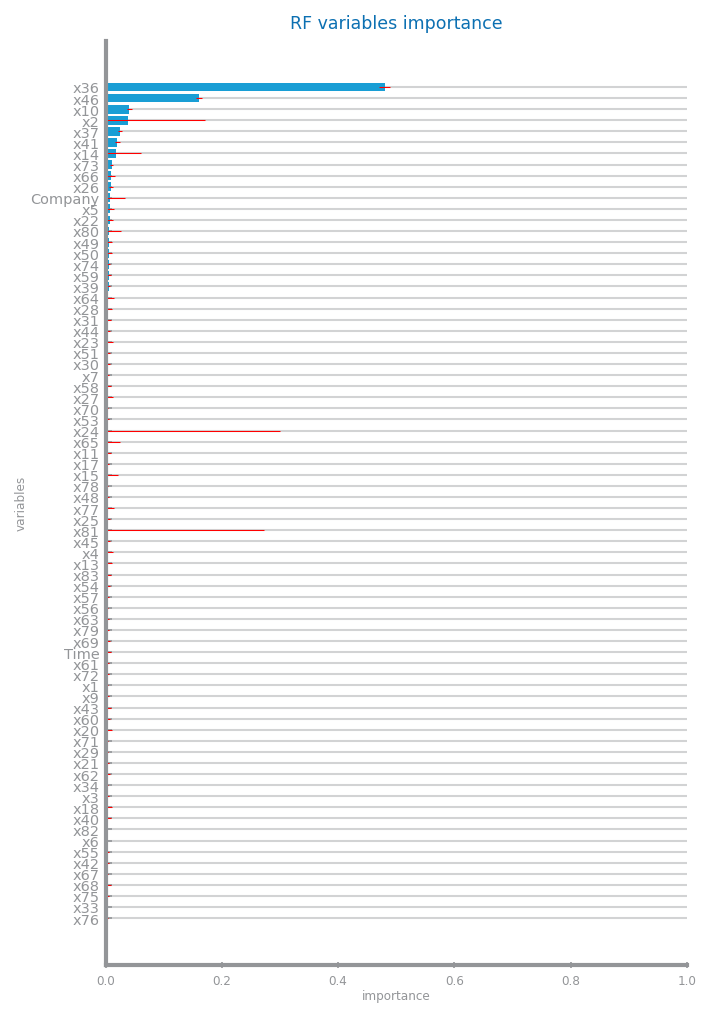

In [31]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - RF {eval_metric} vars ranking.png", bbox_inches='tight')

### Overfitting study


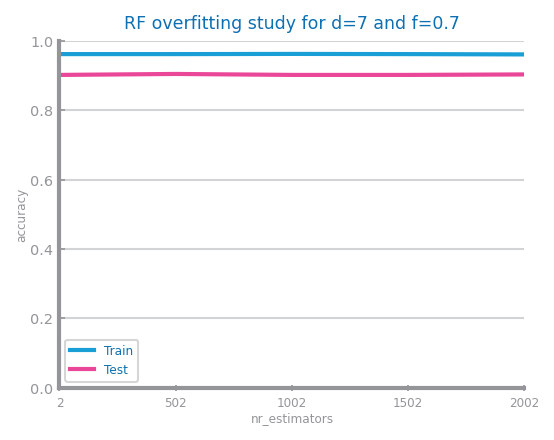

In [32]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - RF {eval_metric} overfitting.png", bbox_inches='tight')

Given the properties of random forests, overfitting is a very unusual occurrence. In this case, it is clear that there is no overfitting, since the accuracy over both datasets almost does not change.

## **Gradient Boosting**
### Paremeters study

Train#=5516 Test#=716
Labels=[np.int64(0), np.int64(1)]
GB best for 500 trees (d=7 and lr=0.5


<Figure size 600x450 with 0 Axes>

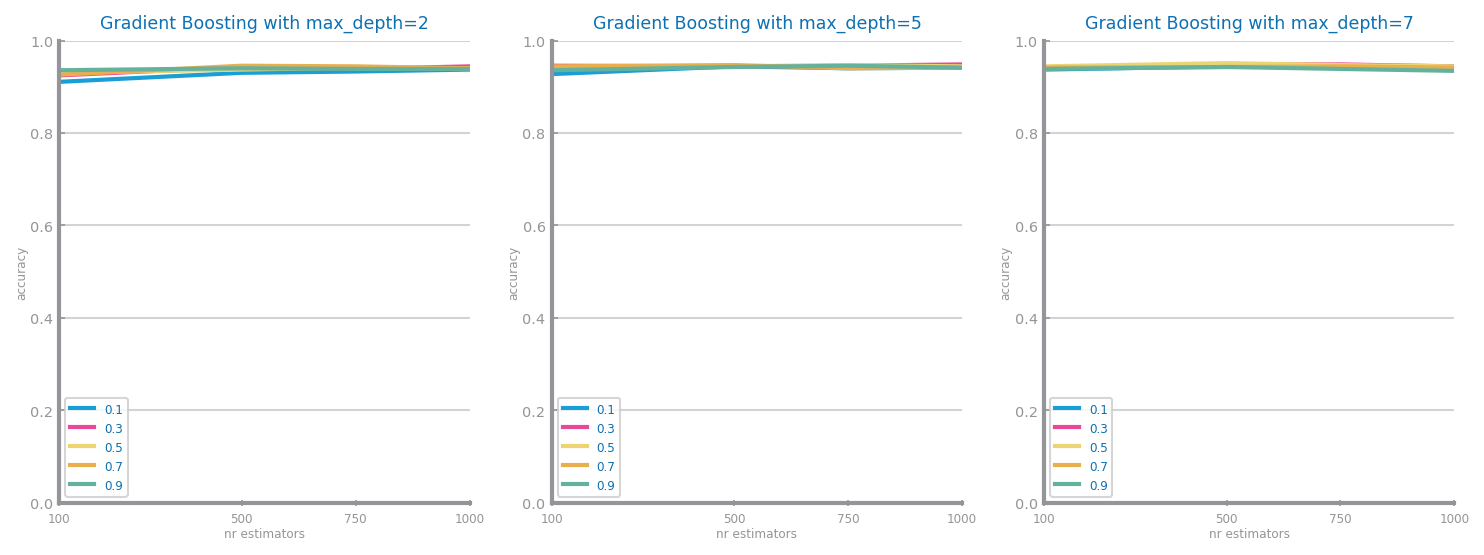

In [33]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f"GB best for {best_params['params'][2]} trees (d={best_params['params'][0]} and lr={best_params['params'][1]}"
    )

    return best_model, best_params


# file_tag = "stroke"
# train_filename = "data/stroke_train_smote.csv"
# test_filename = "data/stroke_test.csv"
# target = "stroke"
# eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/Set 2 - GB {eval_metric} study.png", bbox_inches='tight')
show()

### Best model performance


<Figure size 600x450 with 0 Axes>

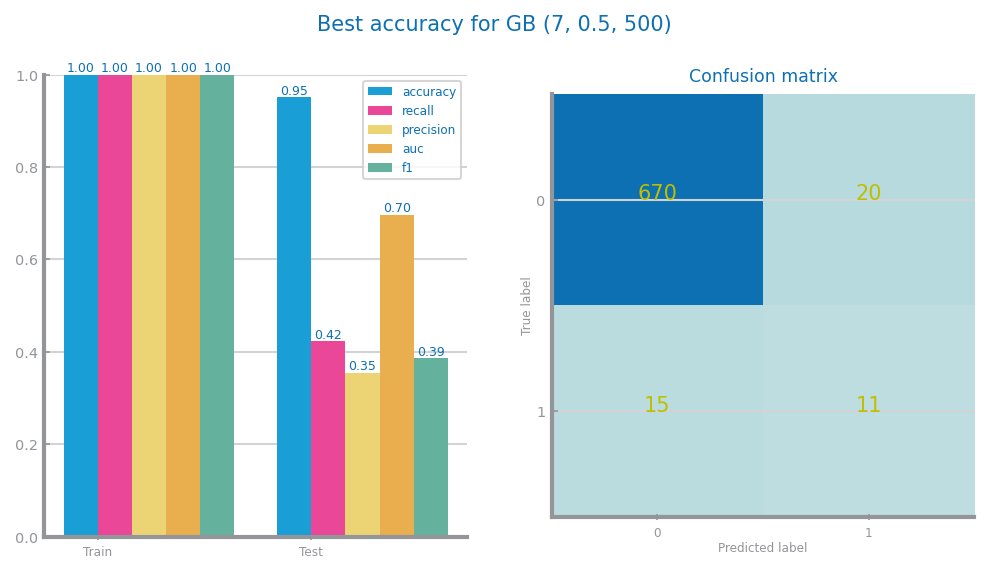

In [34]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 2 - GB {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Variables importance

1. x36 (0.5869635328127736)
2. x10 (0.04452759798971266)
3. x14 (0.04410207169196628)
4. x37 (0.024866604685687438)
5. x73 (0.023216472381619443)
6. x31 (0.022273764644418784)
7. x64 (0.013291289117583906)
8. x58 (0.011603808058711642)
9. x74 (0.011467352679061798)
10. x51 (0.011204927556501513)
11. x30 (0.010431961906854786)
12. x53 (0.009739754099741973)
13. Company (0.009505994898025857)
14. x5 (0.009036851854403758)
15. x66 (0.008844457263447998)
16. x15 (0.008565758089022827)
17. x4 (0.008311426246435862)
18. x44 (0.008033119267063012)
19. x48 (0.006936269563006265)
20. x27 (0.006247992302378334)
21. x39 (0.006050612966455688)
22. x22 (0.006027902855669178)
23. x80 (0.005937437055054671)
24. x61 (0.005227530650805352)
25. x69 (0.004976022131304471)
26. x34 (0.004728916227673441)
27. x41 (0.004421691613089262)
28. x9 (0.0041502923303829735)
29. x49 (0.004047600518767837)
30. x2 (0.0036306137876876837)
31. x26 (0.003452635137188402)
32. x59 (0.0034225374428665124)
33. x17 (0.0032407

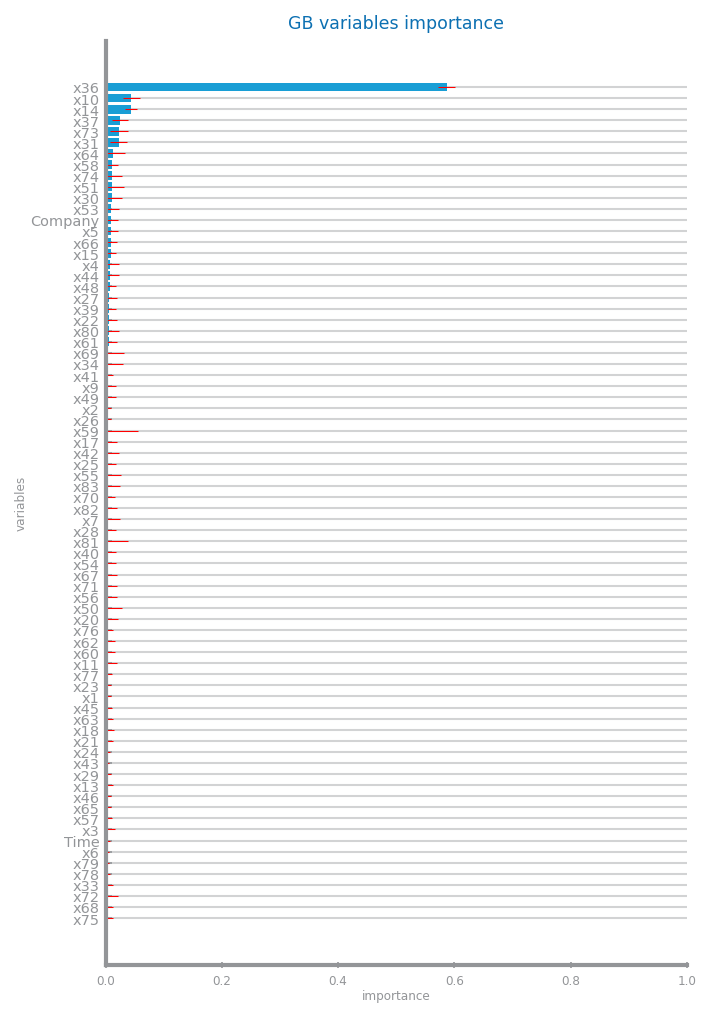

In [35]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - GB {eval_metric} vars ranking.png", bbox_inches='tight')

### Overfitting study


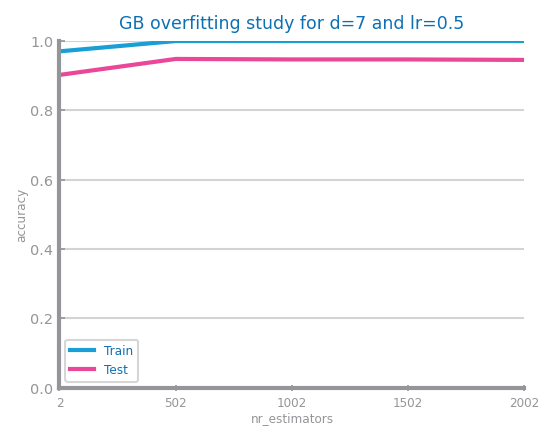

In [36]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 2 - GB {eval_metric} overfitting.png", bbox_inches='tight')